<a href="https://colab.research.google.com/github/gautam-pai/Image-Classification-CIFAR10-Dataset/blob/main/CIFAR10_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Import Datasets

In [3]:
train_data=datasets.CIFAR10(root="./data",train=True,transform=transforms.ToTensor(),download=True)
test_data=datasets.CIFAR10(root="./data",train=False,transform=transforms.ToTensor(),download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
class_names = train_data.classes

## Data Exploration

torch.Size([3, 32, 32])


Text(0.5, 1.0, 'frog')

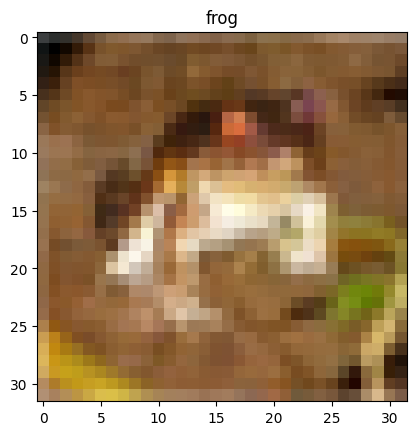

In [7]:
print(train_data[0][0].shape)
sample_image=train_data[0][0]
sample_tag=train_data[0][1]
sample_image=sample_image.permute(1,2,0)
plt.imshow(sample_image)
plt.title(class_names[sample_tag])

torch.Size([3, 32, 32])


Text(0.5, 1.0, 'ship')

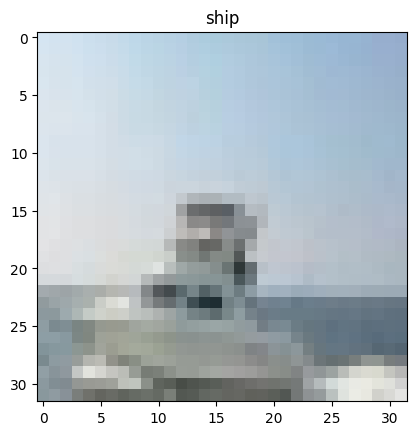

In [8]:
print(train_data[100][0].shape)
sample_image=train_data[100][0]
sample_tag=train_data[100][1]
sample_image=sample_image.permute(1,2,0)
plt.imshow(sample_image)
plt.title(class_names[sample_tag])

torch.Size([3, 32, 32])


Text(0.5, 1.0, 'dog')

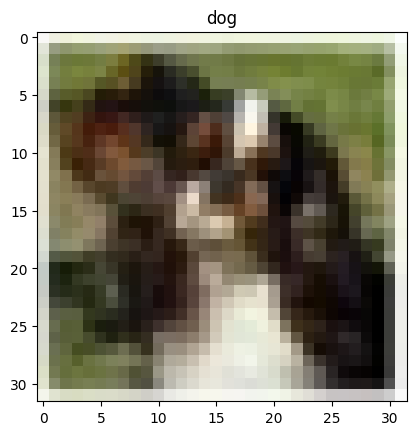

In [9]:
print(train_data[500][0].shape)
sample_image=train_data[500][0]
sample_tag=train_data[500][1]
sample_image=sample_image.permute(1,2,0)
plt.imshow(sample_image)
plt.title(class_names[sample_tag])

torch.Size([3, 32, 32])


Text(0.5, 1.0, 'frog')

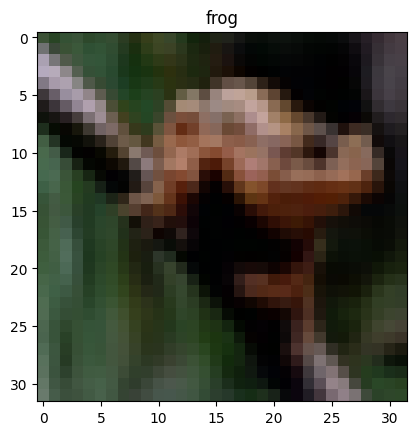

In [10]:
print(train_data[5000][0].shape)
sample_image=train_data[5000][0]
sample_tag=train_data[5000][1]
sample_image=sample_image.permute(1,2,0)
plt.imshow(sample_image)
plt.title(class_names[sample_tag])

## Creating batches of datasets

In [11]:
## Creating a small batch size of 10
train_loader=DataLoader(train_data,batch_size=10,shuffle=False)
test_loader=DataLoader(test_data,batch_size=10, shuffle=False)

## Defining the CNN Model

In [12]:
class Cifar10Model(nn.Module):
  def __init__(self):
    super().__init__()
    ## Conv Layers
    self.conv1=nn.Conv2d(in_channels=3,out_channels=10,kernel_size=3,stride=1)
    self.conv2=nn.Conv2d(in_channels=10,out_channels=20,kernel_size=3,stride=1)
    self.conv3=nn.Conv2d(in_channels=20,out_channels=40,kernel_size=3,stride=1)

    ## Fully Connected Layers
    self.fc1=nn.Linear(2*2*40,80)
    self.fc2=nn.Linear(80,40)
    self.fc3=nn.Linear(40,10)


  def forward(self,X):
    # ReLU activation function and Max Pooling layer
    X=F.relu(self.conv1(X))
    X=F.max_pool2d(X,kernel_size=2,stride=2)
    X=F.relu(self.conv2(X))
    X=F.max_pool2d(X,kernel_size=2,stride=2)
    X=F.relu(self.conv3(X))
    X=F.max_pool2d(X,kernel_size=2,stride=2)

    # Flattening
    X=X.view(-1,2*2*40)

    ## ANN layers
    X=F.relu(self.fc1(X))
    X=F.relu(self.fc2(X))
    X=self.fc3(X)

    # retunrn the value using log softmax function
    return F.log_softmax(X,dim=1)



In [13]:
Detector=Cifar10Model()

In [14]:
Detector

Cifar10Model(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=160, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=10, bias=True)
)

In [15]:

## Loss Function optimizer
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(Detector.parameters(),lr=0.001)

## Training the  model

In [16]:
# Record the training time
import time
start_time=time.time()
epochs=20
# tracking the losses & correct ones
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
losses=[]
for i in range(epochs):
  trn_corr=0
  tst_corr=0

  #training
  for b,(X_Train,y_train) in enumerate(train_loader):
    b+=1
    y_pred=Detector(X_Train)
    loss=criterion(y_pred,y_train)
    losses.append(loss)
    predicted=torch.max(y_pred.data,1)[1]
    batch_corr=(predicted==y_train).sum().item()
    trn_corr+=batch_corr

    #update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%500==0:
      print(f"Epochs: {i+1} Batch: {b} Loss: {loss.item()}")
  train_losses.append(loss.item())
  train_correct.append(trn_corr/len(train_data))

  # Testing

  tst_corr=0
  with torch.no_grad():
    for b,(X_Test,y_test) in enumerate(test_loader):
      y_val=Detector(X_Test)
      predicted=torch.max(y_val.data,1)[1]
      tst_corr+=(predicted==y_test).sum().item()
  loss=criterion(y_val,y_test)

  test_losses.append(loss.item())
  test_correct.append(tst_corr/len(test_data))


current_time=time.time()
total=current_time-start_time

Epochs: 1 Batch: 500 Loss: 2.1060938835144043
Epochs: 1 Batch: 1000 Loss: 1.7522914409637451
Epochs: 1 Batch: 1500 Loss: 2.2432310581207275
Epochs: 1 Batch: 2000 Loss: 1.6840404272079468
Epochs: 1 Batch: 2500 Loss: 1.6130821704864502
Epochs: 1 Batch: 3000 Loss: 1.2582757472991943
Epochs: 1 Batch: 3500 Loss: 1.6924927234649658
Epochs: 1 Batch: 4000 Loss: 1.8928182125091553
Epochs: 1 Batch: 4500 Loss: 2.349870204925537
Epochs: 1 Batch: 5000 Loss: 2.307222366333008
Epochs: 2 Batch: 500 Loss: 1.352423906326294
Epochs: 2 Batch: 1000 Loss: 1.539705514907837
Epochs: 2 Batch: 1500 Loss: 1.5749419927597046
Epochs: 2 Batch: 2000 Loss: 1.0913708209991455
Epochs: 2 Batch: 2500 Loss: 1.2923935651779175
Epochs: 2 Batch: 3000 Loss: 1.1449522972106934
Epochs: 2 Batch: 3500 Loss: 1.5184876918792725
Epochs: 2 Batch: 4000 Loss: 1.5138418674468994
Epochs: 2 Batch: 4500 Loss: 2.13165545463562
Epochs: 2 Batch: 5000 Loss: 2.3755900859832764
Epochs: 3 Batch: 500 Loss: 1.116648554801941
Epochs: 3 Batch: 1000 L

## Loss Visualization

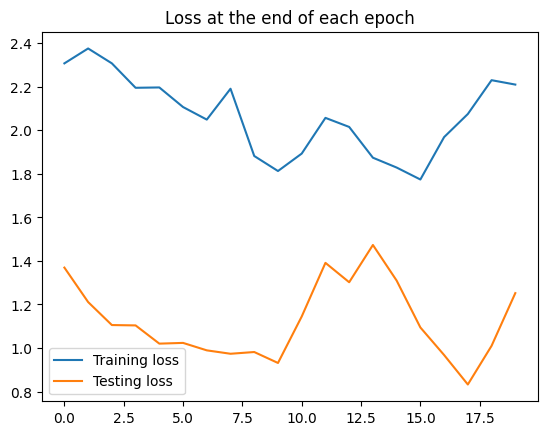

In [17]:
# Loss
plt.plot(train_losses,label="Training loss")
plt.plot(test_losses,label="Testing loss")
plt.title("Loss at the end of each epoch")
plt.legend()

## Accuracy Visualization

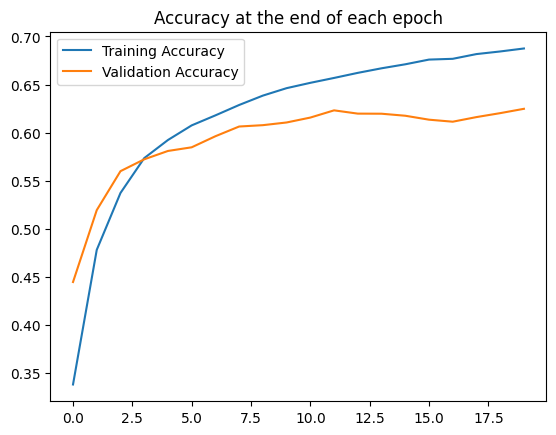

In [18]:
#graph the accuracy at the end of each epoch

plt.plot([t for t in train_correct],label="Training Accuracy")
plt.plot([t for t in test_correct],label="Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [19]:
train_correct

[0.33832,
 0.4782,
 0.53734,
 0.57354,
 0.59238,
 0.60758,
 0.61798,
 0.62878,
 0.63852,
 0.64626,
 0.6518,
 0.65688,
 0.66216,
 0.6669,
 0.67106,
 0.67596,
 0.67676,
 0.68168,
 0.6844,
 0.6875]

In [20]:
test_correct

[0.4448,
 0.5195,
 0.56,
 0.5723,
 0.581,
 0.5848,
 0.5963,
 0.6064,
 0.6078,
 0.6106,
 0.6157,
 0.6232,
 0.6198,
 0.6197,
 0.6176,
 0.6135,
 0.6114,
 0.6162,
 0.6203,
 0.6248]

In [21]:
train_losses

[2.307222366333008,
 2.3755900859832764,
 2.307300567626953,
 2.1950693130493164,
 2.1966347694396973,
 2.1067004203796387,
 2.048973798751831,
 2.1907496452331543,
 1.881860375404358,
 1.8128654956817627,
 1.8929319381713867,
 2.0569469928741455,
 2.015282392501831,
 1.8740463256835938,
 1.8288309574127197,
 1.773929238319397,
 1.9685777425765991,
 2.0747287273406982,
 2.229977607727051,
 2.2098381519317627]

In [22]:
test_losses

[1.369418740272522,
 1.211211085319519,
 1.1056288480758667,
 1.1039373874664307,
 1.0202789306640625,
 1.023627758026123,
 0.989422619342804,
 0.973763108253479,
 0.9817411303520203,
 0.9314683079719543,
 1.1447886228561401,
 1.3911906480789185,
 1.3021948337554932,
 1.473285436630249,
 1.3097561597824097,
 1.0945067405700684,
 0.9679449796676636,
 0.832715630531311,
 1.0101962089538574,
 1.252241611480713]

In [23]:
len(train_loader)

5000

In [24]:
len(test_loader)

1000

In [25]:

new=[t.item() for t in losses]

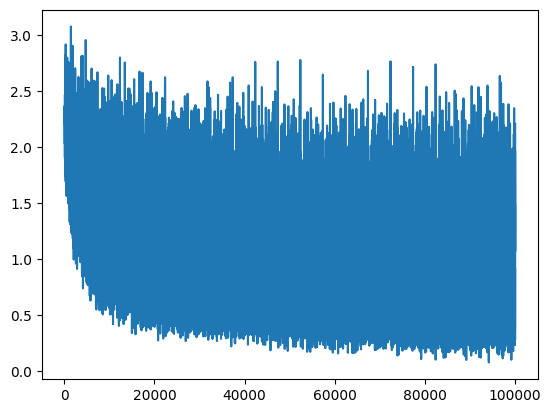

In [26]:
plt.plot(new)